<a href="https://colab.research.google.com/github/juanchess98/Notebooks-Deep-Learning/blob/image_segmentation/Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import zipfile
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
import seaborn as sns

Dataset

| Value  | Class Name    |
| -------| -------------| 
| 0      | sky |
| 1      | building      |
| 2      | column/pole      |
| 3      | road |
| 4      | side walk     |
| 5      | vegetation      |
| 6      | traffic light |
| 7      | fence      |
| 8      | vehicle     |
| 9      | pedestrian |
| 10      | byciclist      |
| 11      | void      |

In [2]:
# download the dataset (zipped file)
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/fcnn-dataset.zip \
    -O /tmp/fcnn-dataset.zip

# extract the downloaded dataset to a local directory: /tmp/fcnn
local_zip = '/tmp/fcnn-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/fcnn')
zip_ref.close()

--2021-07-19 16:12:45--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/fcnn-dataset.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 125577577 (120M) [application/zip]
Saving to: ‘/tmp/fcnn-dataset.zip’

/tmp/fcnn-dataset.z 100%[===================>] 119.76M  96.5MB/s    in 1.2s    

2021-07-19 16:12:47 (96.5 MB/s) - ‘/tmp/fcnn-dataset.zip’ saved [125577577/125577577]



In [3]:
# pixel labels in the video frames
class_names = ['sky', 'building','column/pole', 'road', 'side walk', 'vegetation', 'traffic light', 'fence', 'vehicle', 'pedestrian', 'byciclist', 'void']

Next, you will load and prepare the train and validation sets for training. There are some preprocessing steps needed before the data is fed to the model. These include:

* resizing the height and width of the input images and label maps (224 x 224px by default)
* normalizing the input images' pixel values to fall in the range `[-1, 1]`
* reshaping the label maps from `(height, width, 1)` to `(height, width, 12)` with each slice along the third axis having `1` if it belongs to the class corresponding to that slice's index else `0`. For example, if a pixel is part of a road, then using the table above, that point at slice #3 will be labeled `1` and it will be `0` in all other slices. To illustrate using simple arrays:
```
# if we have a label map with 3 classes...
n_classes = 3
# and this is the original annotation...
orig_anno = [0 1 2]
# then the reshaped annotation will have 3 slices and its contents will look like this:
reshaped_anno = [1 0 0][0 1 0][0 0 1]
```

The following function will do the preprocessing steps mentioned above.

In [4]:
def map_filename_to_image_and_mask(t_filename, a_filename, height=128, width=128):
  '''
  Preprocesses the dataset by:
    * resizing the input image and label maps
    * normalizing the input image pixels
    * reshaping the label maps from (height, width, 1) to (height, width, 12)

  Args:
    t_filename (string) -- path to the raw input image
    a_filename (string) -- path to the raw annotation (label map) file
    height (int) -- height in pixels to resize to
    width (int) -- width in pixels to resize to

  Returns:
    image (tensor) -- preprocessed image
    annotation (tensor) -- preprocessed annotation
  '''

  # Convert image and mask files to tensors 
  img_raw = tf.io.read_file(t_filename)
  anno_raw = tf.io.read_file(a_filename)
  image = tf.image.decode_jpeg(img_raw)
  annotation = tf.image.decode_jpeg(anno_raw)
 
  # Resize image and segmentation mask
  image = tf.image.resize(image, (height, width,))
  annotation = tf.image.resize(annotation, (height, width,))
  image = tf.reshape(image, (height, width, 3,))
  annotation = tf.cast(annotation, dtype=tf.int32)
  annotation = tf.reshape(annotation, (height, width, 1,))
  stack_list = []

  # Reshape segmentation masks
  for c in range(len(class_names)):
    mask = tf.equal(annotation[:,:,0], tf.constant(c))
    stack_list.append(tf.cast(mask, dtype=tf.int32))
  
  annotation = tf.stack(stack_list, axis=2)

  # Normalize pixels in the input image
  image = image/127.5
  image -= 1

  return image, annotation

In [5]:
# show folders inside the dataset you downloaded
!ls /tmp/fcnn/dataset1

annotations_prepped_test   images_prepped_test
annotations_prepped_train  images_prepped_train


In [6]:
# Utilities for preparing the datasets

BATCH_SIZE = 64

def get_dataset_slice_paths(image_dir, label_map_dir):
  '''
  generates the lists of image and label map paths
  
  Args:
    image_dir (string) -- path to the input images directory
    label_map_dir (string) -- path to the label map directory

  Returns:
    image_paths (list of strings) -- paths to each image file
    label_map_paths (list of strings) -- paths to each label map
  '''
  image_file_list = os.listdir(image_dir)
  label_map_file_list = os.listdir(label_map_dir)
  image_paths = [os.path.join(image_dir, fname) for fname in image_file_list]
  label_map_paths = [os.path.join(label_map_dir, fname) for fname in label_map_file_list]

  return image_paths, label_map_paths


def get_training_dataset(image_paths, label_map_paths):
  '''
  Prepares shuffled batches of the training set.
  
  Args:
    image_paths (list of strings) -- paths to each image file in the train set
    label_map_paths (list of strings) -- paths to each label map in the train set

  Returns:
    tf Dataset containing the preprocessed train set
  '''
  training_dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_map_paths))
  training_dataset = training_dataset.map(map_filename_to_image_and_mask)
  training_dataset = training_dataset.shuffle(100, reshuffle_each_iteration=True)
  training_dataset = training_dataset.batch(BATCH_SIZE)
  training_dataset = training_dataset.repeat()
  training_dataset = training_dataset.prefetch(-1)

  return training_dataset


def get_validation_dataset(image_paths, label_map_paths):
  '''
  Prepares batches of the validation set.
  
  Args:
    image_paths (list of strings) -- paths to each image file in the val set
    label_map_paths (list of strings) -- paths to each label map in the val set

  Returns:
    tf Dataset containing the preprocessed validation set
  '''
  validation_dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_map_paths))
  validation_dataset = validation_dataset.map(map_filename_to_image_and_mask)
  validation_dataset = validation_dataset.batch(BATCH_SIZE)
  validation_dataset = validation_dataset.repeat()  

  return validation_dataset

In [7]:
# get the paths to the images
training_image_paths, training_label_map_paths = get_dataset_slice_paths('/tmp/fcnn/dataset1/images_prepped_train/','/tmp/fcnn/dataset1/annotations_prepped_train/')
validation_image_paths, validation_label_map_paths = get_dataset_slice_paths('/tmp/fcnn/dataset1/images_prepped_test/','/tmp/fcnn/dataset1/annotations_prepped_test/')

# generate the train and val sets
training_dataset = get_training_dataset(training_image_paths, training_label_map_paths)
validation_dataset = get_validation_dataset(validation_image_paths, validation_label_map_paths)

Let's take a look at the Dataset

You will also need utilities to help visualize the dataset and the model predictions later. First, you need to assign a color mapping to the classes in the label maps. Since our dataset has 12 classes, you need to have a list of 12 colors. We can use the color_palette() from Seaborn to generate this.

In [8]:
# generate a list that contains one color for each class
colors = sns.color_palette(None, len(class_names))

# print class name - normalized RGB tuple pairs
# the tuple values will be multiplied by 255 in the helper functions later
# to convert to the (0,0,0) to (255,255,255) RGB values you might be familiar with
for class_name, color in zip(class_names, colors):
  print(f'{class_name} -- {color}')

sky -- (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
building -- (1.0, 0.4980392156862745, 0.054901960784313725)
column/pole -- (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)
road -- (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)
side walk -- (0.5803921568627451, 0.403921568627451, 0.7411764705882353)
vegetation -- (0.5490196078431373, 0.33725490196078434, 0.29411764705882354)
traffic light -- (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)
fence -- (0.4980392156862745, 0.4980392156862745, 0.4980392156862745)
vehicle -- (0.7372549019607844, 0.7411764705882353, 0.13333333333333333)
pedestrian -- (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)
byciclist -- (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
void -- (1.0, 0.4980392156862745, 0.054901960784313725)


In [9]:
# Visualization Utilities

def fuse_with_pil(images):
  '''
  Creates a blank image and pastes input images

  Args:
    images (list of numpy arrays) - numpy array representations of the images to paste
  
  Returns:
    PIL Image object containing the images
  '''

  widths = (image.shape[1] for image in images)
  heights = (image.shape[0] for image in images)
  total_width = sum(widths)
  max_height = max(heights)

  new_im = PIL.Image.new('RGB', (total_width, max_height))

  x_offset = 0
  for im in images:
    pil_image = PIL.Image.fromarray(np.uint8(im))
    new_im.paste(pil_image, (x_offset,0))
    x_offset += im.shape[1]
  
  return new_im


def give_color_to_annotation(annotation):
  '''
  Converts a 2-D annotation to a numpy array with shape (height, width, 3) where
  the third axis represents the color channel. The label values are multiplied by
  255 and placed in this axis to give color to the annotation

  Args:
    annotation (numpy array) - label map array
  
  Returns:
    the annotation array with an additional color channel/axis
  '''
  seg_img = np.zeros( (annotation.shape[0],annotation.shape[1], 3) ).astype('float')
  
  for c in range(12):
    segc = (annotation == c)
    seg_img[:,:,0] += segc*( colors[c][0] * 255.0)
    seg_img[:,:,1] += segc*( colors[c][1] * 255.0)
    seg_img[:,:,2] += segc*( colors[c][2] * 255.0)
  
  return seg_img


def show_predictions(image, labelmaps, titles, iou_list, dice_score_list):
  '''
  Displays the images with the ground truth and predicted label maps

  Args:
    image (numpy array) -- the input image
    labelmaps (list of arrays) -- contains the predicted and ground truth label maps
    titles (list of strings) -- display headings for the images to be displayed
    iou_list (list of floats) -- the IOU values for each class
    dice_score_list (list of floats) -- the Dice Score for each vlass
  '''

  true_img = give_color_to_annotation(labelmaps[1])
  pred_img = give_color_to_annotation(labelmaps[0])

  image = image + 1
  image = image * 127.5
  images = np.uint8([image, pred_img, true_img])

  metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0]
  metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place
  
  display_string_list = ["{}: IOU: {} Dice Score: {}".format(class_names[idx], iou, dice_score) for idx, iou, dice_score in metrics_by_id]
  display_string = "\n\n".join(display_string_list) 

  plt.figure(figsize=(15, 4))

  for idx, im in enumerate(images):
    plt.subplot(1, 3, idx+1)
    if idx == 1:
      plt.xlabel(display_string)
    plt.xticks([])
    plt.yticks([])
    plt.title(titles[idx], fontsize=12)
    plt.imshow(im)


def show_annotation_and_image(image, annotation):
  '''
  Displays the image and its annotation side by side

  Args:
    image (numpy array) -- the input image
    annotation (numpy array) -- the label map
  '''
  new_ann = np.argmax(annotation, axis=2)
  seg_img = give_color_to_annotation(new_ann)
  
  image = image + 1
  image = image * 127.5
  image = np.uint8(image)
  images = [image, seg_img]
  
  images = [image, seg_img]
  fused_img = fuse_with_pil(images)
  plt.imshow(fused_img)


def list_show_annotation(dataset):
  '''
  Displays images and its annotations side by side

  Args:
    dataset (tf Dataset) - batch of images and annotations
  '''

  ds = dataset.unbatch()
  ds = ds.shuffle(buffer_size=100)

  plt.figure(figsize=(25, 15))
  plt.title("Images And Annotations")
  plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.05)

  # we set the number of image-annotation pairs to 9
  # feel free to make this a function parameter if you want
  for idx, (image, annotation) in enumerate(ds.take(9)):
    plt.subplot(3, 3, idx + 1)
    plt.yticks([])
    plt.xticks([])
    show_annotation_and_image(image.numpy(), annotation.numpy())


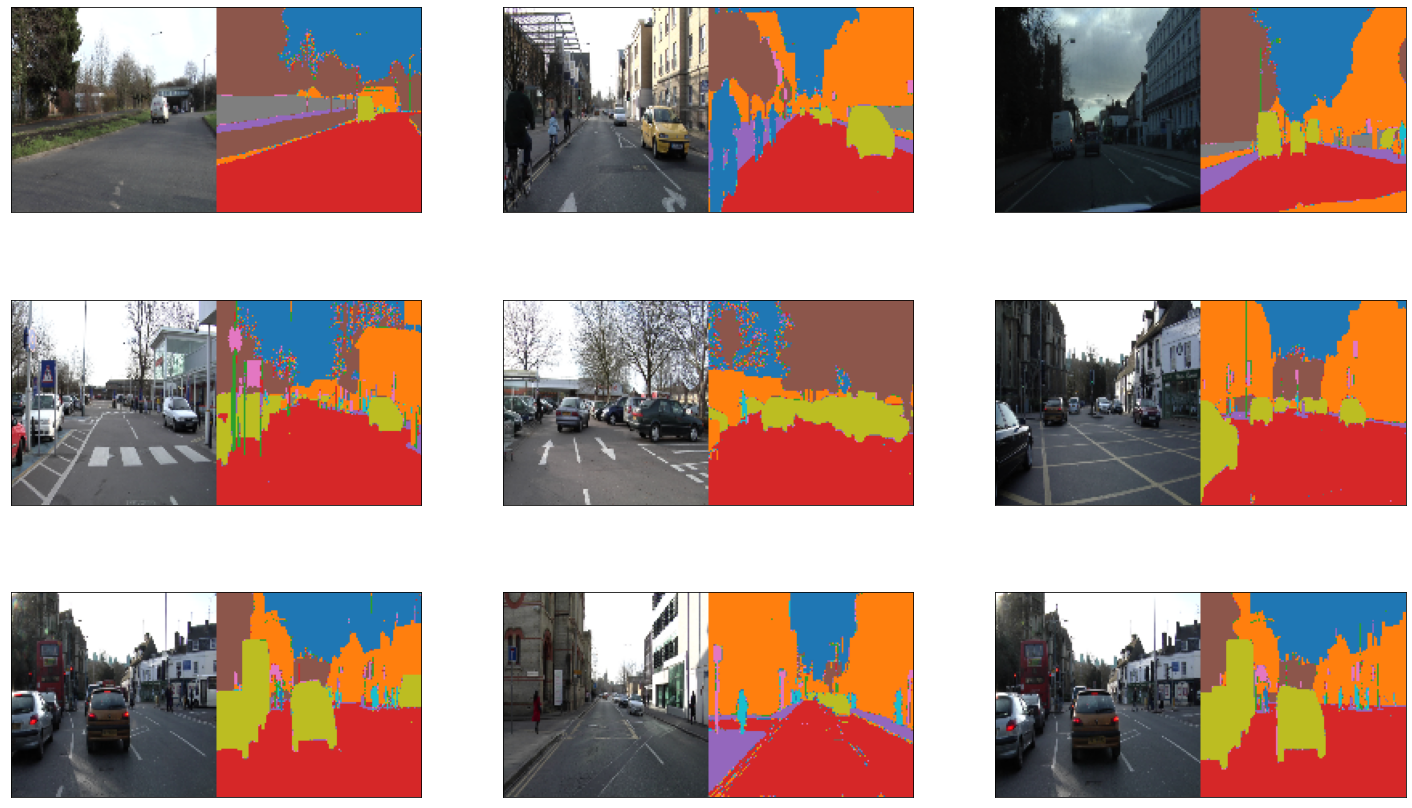

In [10]:
list_show_annotation(training_dataset)

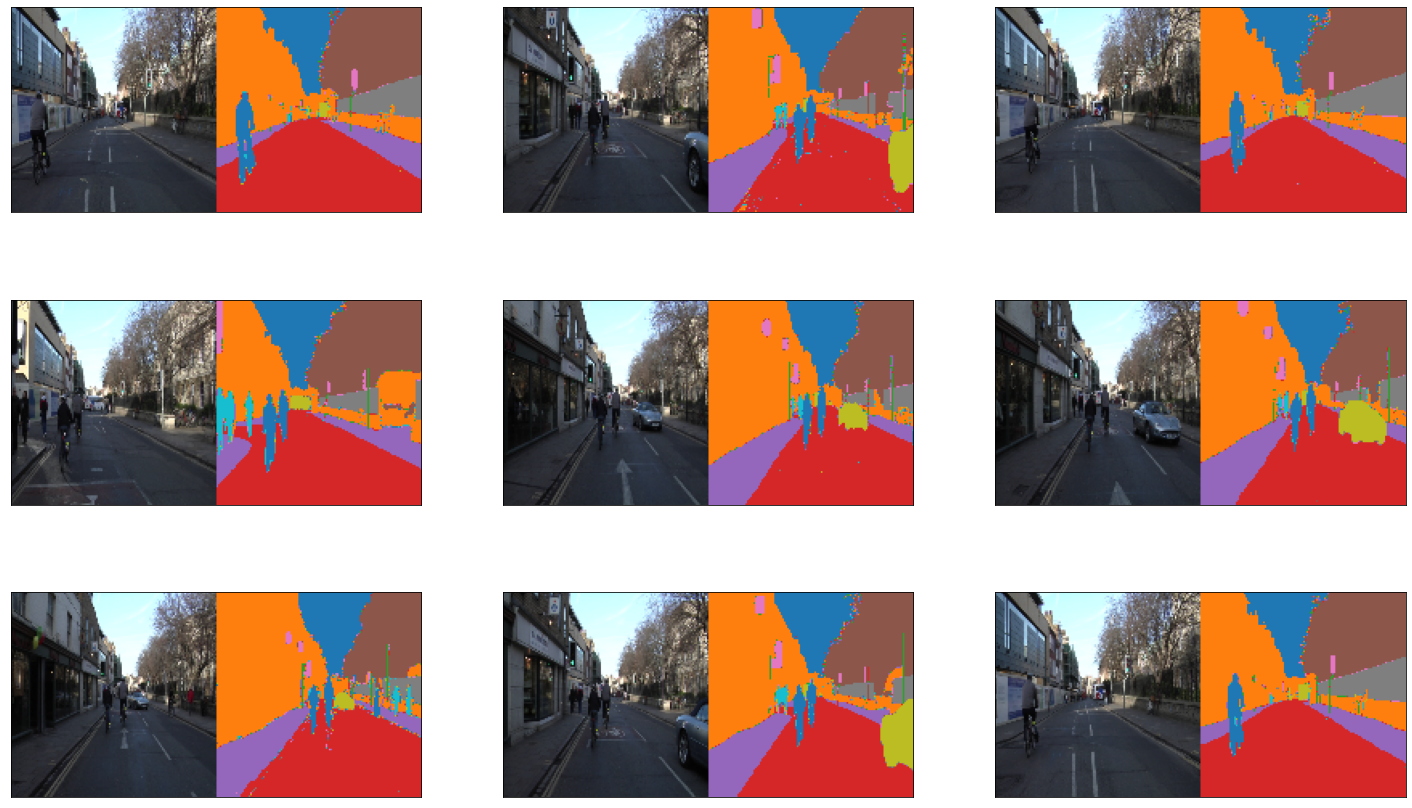

In [11]:
list_show_annotation(validation_dataset)

# Model Definition
<img src='https://drive.google.com/uc?export=view&id=1BeQSKL2Eq6Fw9iRXsN1hgunY-CS2nH7V' alt='unet'>

A UNet consists of an encoder (downsampler) and decoder (upsampler) with a bottleneck in between. The gray arrows correspond to the skip connections that concatenate encoder block outputs to each stage of the decoder. Let's see how to implement these starting with the encoder.

# Encoder 
the encoder will have repeating blocks (red boxes in the figure below) so it's best to create functions for it to make the code modular. These encoder blocks will contain two Conv2D layers activated by ReLU, followed by a MaxPooling and Dropout layer. As discussed in class, each stage will have increasing number of filters and the dimensionality of the features will reduce because of the pooling layer.
The encoder utilities will have three functions:

conv2d_block() - to add two convolution layers and ReLU activations
encoder_block() - to add pooling and dropout to the conv2d blocks. Recall that in UNet, you need to save the output of the convolution layers at each block so this function will return two values to take that into account (i.e. output of the conv block and the dropout)
encoder() - to build the entire encoder. This will return the output of the last encoder block as well as the output of the previous conv blocks. These will be concatenated to the decoder blocks as you'll see later.

<img src='https://drive.google.com/uc?export=view&id=1Gs9K3_8ZBn2_ntOtJL_-_ww4ZOgfyhrS' alt='unet'>

In [12]:
# Encoder Utilities

def conv2d_block(input_tensor, n_filters, kernel_size = 3):
  '''
  Adds 2 convolutional layers with the parameters passed to it

  Args:
    input_tensor (tensor) -- the input tensor
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size for the convolution

  Returns:
    tensor of output features
  '''
  # first layer
  x = input_tensor
  for i in range(2):
    x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
            kernel_initializer = 'he_normal', padding = 'same')(x)
    x = tf.keras.layers.Activation('relu')(x)
  
  return x


def encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3):
  '''
  Adds two convolutional blocks and then perform down sampling on output of convolutions.

  Args:
    input_tensor (tensor) -- the input tensor
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size for the convolution

  Returns:
    f - the output features of the convolution block 
    p - the maxpooled features with dropout
  '''

  f = conv2d_block(inputs, n_filters=n_filters)
  p = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(f)
  p = tf.keras.layers.Dropout(0.3)(p)

  return f, p


def encoder(inputs):
  '''
  This function defines the encoder or downsampling path.

  Args:
    inputs (tensor) -- batch of input images

  Returns:
    p4 - the output maxpooled features of the last encoder block
    (f1, f2, f3, f4) - the output features of all the encoder blocks
  '''
  f1, p1 = encoder_block(inputs, n_filters=64, pool_size=(2,2), dropout=0.3)
  f2, p2 = encoder_block(p1, n_filters=128, pool_size=(2,2), dropout=0.3)
  f3, p3 = encoder_block(p2, n_filters=256, pool_size=(2,2), dropout=0.3)
  f4, p4 = encoder_block(p3, n_filters=512, pool_size=(2,2), dropout=0.3)

  return p4, (f1, f2, f3, f4)

# Bottleneck
A bottleneck follows the encoder block and is used to extract more features. This does not have a pooling layer so the dimensionality remains the same. You can use the conv2d_block() function defined earlier to implement this.

In [13]:
def bottleneck(inputs):
  '''
  This function defines the bottleneck convolutions to extract more features before the upsampling layers.
  '''
  
  bottle_neck = conv2d_block(inputs, n_filters=1024)

  return bottle_neck

# Decoder 
Finally, we have the decoder which upsamples the features back to the original image size. At each upsampling level, you will take the output of the corresponding encoder block and concatenate it before feeding to the next decoder block. This is summarized in the figure below.
<img src='https://drive.google.com/uc?export=view&id=1Ql5vdw6l88vxaHgk7VjcMc4vfyoWYx2w' alt='unet_decoder'>

In [14]:
# Decoder Utilities

def decoder_block(inputs, conv_output, n_filters=64, kernel_size=3, strides=3, dropout=0.3):
  '''
  defines the one decoder block of the UNet

  Args:
    inputs (tensor) -- batch of input features
    conv_output (tensor) -- features from an encoder block
    n_filters (int) -- number of filters
    kernel_size (int) -- kernel size
    strides (int) -- strides for the deconvolution/upsampling
    padding (string) -- "same" or "valid", tells if shape will be preserved by zero padding

  Returns:
    c (tensor) -- output features of the decoder block
  '''
  u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides = strides, padding = 'same')(inputs)
  c = tf.keras.layers.concatenate([u, conv_output])
  c = tf.keras.layers.Dropout(dropout)(c)
  c = conv2d_block(c, n_filters, kernel_size=3)

  return c


def decoder(inputs, convs, output_channels):
  '''
  Defines the decoder of the UNet chaining together 4 decoder blocks. 
  
  Args:
    inputs (tensor) -- batch of input features
    convs (tuple) -- features from the encoder blocks
    output_channels (int) -- number of classes in the label map

  Returns:
    outputs (tensor) -- the pixel wise label map of the image
  '''
  
  f1, f2, f3, f4 = convs

  c6 = decoder_block(inputs, f4, n_filters=512, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c7 = decoder_block(c6, f3, n_filters=256, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c8 = decoder_block(c7, f2, n_filters=128, kernel_size=(3,3), strides=(2,2), dropout=0.3)
  c9 = decoder_block(c8, f1, n_filters=64, kernel_size=(3,3), strides=(2,2), dropout=0.3)

  outputs = tf.keras.layers.Conv2D(output_channels, (1, 1), activation='softmax')(c9)

  return outputs

# Putting all together
You can finally build the UNet by chaining the encoder, bottleneck, and decoder. You will specify the number of output channels and in this particular set, that would be 12.

In [15]:
OUTPUT_CHANNELS = 12

def unet():
  '''
  Defines the UNet by connecting the encoder, bottleneck and decoder.
  '''

  # specify the input shape
  inputs = tf.keras.layers.Input(shape=(128, 128,3,))

  # feed the inputs to the encoder
  encoder_output, convs = encoder(inputs)

  # feed the encoder output to the bottleneck
  bottle_neck = bottleneck(encoder_output)

  # feed the bottleneck and encoder block outputs to the decoder
  # specify the number of classes via the `output_channels` argument
  outputs = decoder(bottle_neck, convs, output_channels=OUTPUT_CHANNELS)
  
  # create the model
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model

In [16]:
# instantiate the model
model = unet()

In [17]:

# see the resulting model architecture
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 36928       activation[0][0]                 
______________________________________________________________________________________________

# Compile the model and Train the model

Next, the model will be configured for training. You will need to specify the loss, optimizer and metrics. You will use categorical_crossentropy as the loss function since the label map is transformed to one hot encoded vectors for each pixel in the image (i.e. 1 in one slice and 0 for other slices as described earlier).

In [18]:
# configure the optimizer, loss and metrics for training
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='categorical_crossentropy',
              metrics=['accuracy'])

In [22]:
# Callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("unet_seg_model.h5", save_best_only=True)
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)


In [23]:
# number of training images
train_count = 367

# number of validation images
validation_count = 101

EPOCHS = 100

steps_per_epoch = train_count//BATCH_SIZE
validation_steps = validation_count//BATCH_SIZE

history = model.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch, validation_data=validation_dataset, validation_steps=validation_steps, epochs=EPOCHS, callbacks=[checkpoint_cb, early_stopping_cb] )

Epoch 1/100
5/5 [==============================] - 6s 1s/step - loss: 1.3205 - accuracy: 0.6286 - val_loss: 1.4526 - val_accuracy: 0.5737
Epoch 2/100
5/5 [==============================] - 6s 1s/step - loss: 1.2399 - accuracy: 0.6615 - val_loss: 1.4447 - val_accuracy: 0.5755
Epoch 3/100
5/5 [==============================] - 5s 1s/step - loss: 1.1741 - accuracy: 0.6721 - val_loss: 1.2934 - val_accuracy: 0.6112
Epoch 4/100
5/5 [==============================] - 5s 997ms/step - loss: 1.1079 - accuracy: 0.6822 - val_loss: 1.3153 - val_accuracy: 0.6023
Epoch 5/100
5/5 [==============================] - 5s 1s/step - loss: 1.0777 - accuracy: 0.6814 - val_loss: 1.2063 - val_accuracy: 0.6127
Epoch 6/100
5/5 [==============================] - 5s 1s/step - loss: 1.0793 - accuracy: 0.6807 - val_loss: 1.2033 - val_accuracy: 0.6127
Epoch 7/100
5/5 [==============================] - 5s 1s/step - loss: 1.0444 - accuracy: 0.6866 - val_loss: 1.2203 - val_accuracy: 0.6102
Epoch 8/100
5/5 [==============

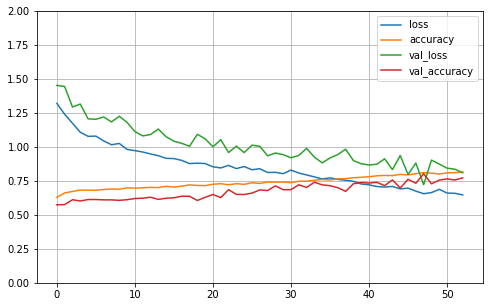

In [24]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 2) # set the vertical range to [0-1]
plt.show()

# Evaluate the model
After training, you will want to see how your model is doing on a test set. For segmentation models, you can use the intersection-over-union and the dice score as metrics to evaluate your model. You'll see how it is implemented in this section.

In [25]:
def get_images_and_segments_test_arrays():
  '''
  Gets a subsample of the val set as your test set

  Returns:
    Test set containing ground truth images and label maps
  '''
  y_true_segments = []
  y_true_images = []
  test_count = 64

  ds = validation_dataset.unbatch()
  ds = ds.batch(101)

  for image, annotation in ds.take(1):
    y_true_images = image
    y_true_segments = annotation


  y_true_segments = y_true_segments[:test_count, : ,: , :]
  y_true_segments = np.argmax(y_true_segments, axis=3)  

  return y_true_images, y_true_segments

# load the ground truth images and segmentation masks
y_true_images, y_true_segments = get_images_and_segments_test_arrays()

# Make Predictions

You can get output segmentation masks by using the `predict()` method. As you may recall, the output of our segmentation model has the shape `(height, width, 12)` where `12` is the number of classes. Each pixel value in those 12 slices indicates the probability of that pixel belonging to that particular class. If you want to create the predicted label map, then you can get the `argmax()` of that axis. This is shown in the following cell.


In [26]:
# get the model prediction
results = model.predict(validation_dataset, steps=validation_steps)

# for each pixel, get the slice number which has the highest probability
results = np.argmax(results, axis=3)

### Compute Metrics

The function below generates the IOU and dice score of the prediction and ground truth masks. From the lectures, it is given that:

$$IOU = \frac{area\_of\_overlap}{area\_of\_union}$$
<br>
$$Dice Score = 2 * \frac{area\_of\_overlap}{combined\_area}$$

The code below does that for you. A small smoothening factor is introduced in the denominators to prevent possible division by zero.

In [27]:
def compute_metrics(y_true, y_pred):
  '''
  Computes IOU and Dice Score.

  Args:
    y_true (tensor) - ground truth label map
    y_pred (tensor) - predicted label map
  '''
  
  class_wise_iou = []
  class_wise_dice_score = []

  smoothening_factor = 0.00001

  for i in range(12):
    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area
    
    iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
    class_wise_iou.append(iou)
    
    dice_score =  2 * ((intersection + smoothening_factor) / (combined_area + smoothening_factor))
    class_wise_dice_score.append(dice_score)

  return class_wise_iou, class_wise_dice_score

##Show Predictions and Metrics

You can now see the predicted segmentation masks side by side with the ground truth. The metrics are also overlayed so you can evaluate how your model is doing.

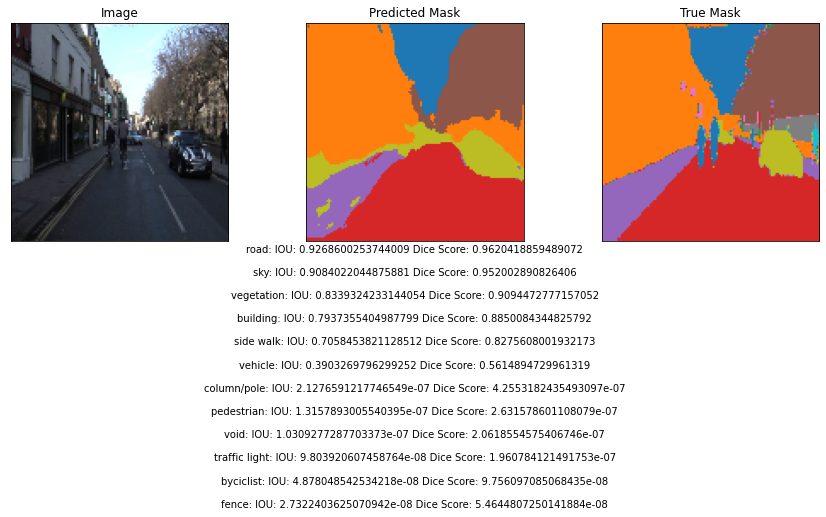

In [31]:
# input a number from 0 to 63 to pick an image from the test set
integer_slider = 60

# compute metrics
iou, dice_score = compute_metrics(y_true_segments[integer_slider], results[integer_slider])  

# visualize the output and metrics
show_predictions(y_true_images[integer_slider], [results[integer_slider], y_true_segments[integer_slider]], ["Image", "Predicted Mask", "True Mask"], iou, dice_score)

# Display Class Wise Metrics
You can also compute the class-wise metrics so you can see how your model performs across all images in the test set.

In [32]:
# compute class-wise metrics
cls_wise_iou, cls_wise_dice_score = compute_metrics(y_true_segments, results)


In [33]:
# print IOU for each class
for idx, iou in enumerate(cls_wise_iou):
  spaces = ' ' * (13-len(class_names[idx]) + 2)
  print("{}{}{} ".format(class_names[idx], spaces, iou)) 


sky            0.9287614039032929 
building       0.7014747428495957 
column/pole    1.432459530966252e-09 
road           0.8641503277069992 
side walk      0.524936243909799 
vegetation     0.7481552999679029 
traffic light  9.555661720443706e-10 
fence          3.2723583876198967e-10 
vehicle        0.21668295103924906 
pedestrian     1.2868356694288566e-09 
byciclist      4.5126353770249846e-10 
void           0.005030543294983441 


In [34]:
# print the dice score for each class
for idx, dice_score in enumerate(cls_wise_dice_score):
  spaces = ' ' * (13-len(class_names[idx]) + 2)
  print("{}{}{} ".format(class_names[idx], spaces, dice_score)) 


sky            0.9630651070392212 
building       0.8245491104819148 
column/pole    2.864919061932504e-09 
road           0.9271251517405458 
side walk      0.6884697587036195 
vegetation     0.8559368838702154 
traffic light  1.9111323440887412e-09 
fence          6.544716775239793e-10 
vehicle        0.35618638508106093 
pedestrian     2.5736713388577132e-09 
byciclist      9.025270754049969e-10 
void           0.010010727200564371 
